# Tarea 2 - Procesamiento distribuido y redes neuronales profundas

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
import os 
import torch
import PIL
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from PIL import Image
from torchvision import models, datasets, transforms
from keras.applications.imagenet_utils import decode_predictions
from skimage.segmentation import slic, mark_boundaries
from skimage.io import imshow
from scipy.stats import bernoulli
from sklearn.metrics import pairwise_distances
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, MiniBatchKMeans
%matplotlib inline
# Path del directorio
path_dir = os.getcwd() + '/drive/My Drive/MA6202/T2'
os.chdir(path_dir)
# Se asigna un valor de reproductibilidad
torch.manual_seed(6202)
#np.random.seed(seed=6202)

In [10]:
os.getcwd()

'/content/drive/My Drive/MA6202/T2'

## P3. Interpretabilidad 

### 1

In [11]:
preprocesamiento = transforms.Compose([transforms.Resize(size=299, interpolation=2),
                                     transforms.CenterCrop(299),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                          std=[0.229, 0.224, 0.225], 
                                                          inplace=True)
                                     ])

### 2

In [12]:
#modelo = torch.hub.load('pytorch/vision:v0.6.0', 'inception_v3', pretrained=True)
modelo = models.inception_v3(pretrained=True)
modelo.eval();

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/checkpoints/inception_v3_google-1a9a5a14.pth


In [13]:
#Se trabaja con la GPU para mayor eficiencia:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")
dev

device(type='cuda')

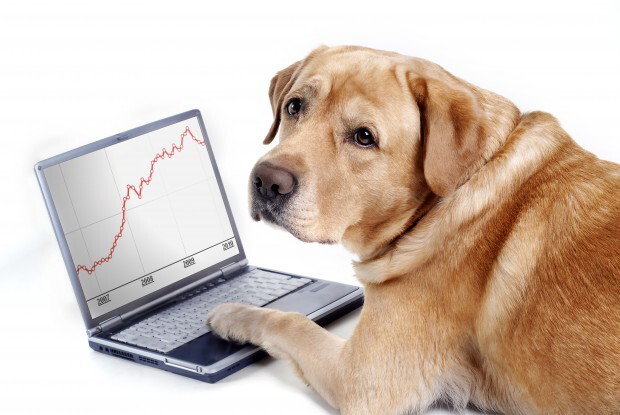

In [14]:
# Se carga la imagen de control
imagen_control = Image.open("imagen_control.jpg")
imagen_control

In [15]:
# Se procesa la imagen de control bajo el preprocesador antes creado
imagen_procesada = preprocesamiento(imagen_control)
imagen_procesada

tensor([[[ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
         [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
         [ 2.2318,  2.2318,  2.2318,  ...,  2.2318,  2.2318,  2.2318],
         ...,
         [ 2.2489,  2.2489,  2.2489,  ...,  0.2624,  0.3652,  0.3994],
         [ 2.2489,  2.2489,  2.2489,  ...,  0.2282,  0.3481,  0.3652],
         [ 2.2489,  2.2489,  2.2489,  ...,  0.1939,  0.2967,  0.3309]],

        [[ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286],
         [ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286],
         [ 2.4111,  2.4111,  2.4111,  ...,  2.4111,  2.4111,  2.4111],
         ...,
         [ 2.4286,  2.4286,  2.4286,  ..., -0.0049,  0.0826,  0.1352],
         [ 2.4286,  2.4286,  2.4286,  ..., -0.0399,  0.0826,  0.1001],
         [ 2.4286,  2.4286,  2.4286,  ..., -0.0749,  0.0301,  0.0651]],

        [[ 2.6400,  2.6400,  2.6400,  ...,  2.6400,  2.6400,  2.6400],
         [ 2.6400,  2.6400,  2.6400,  ...,  2

In [16]:
imagen_procesada.shape

torch.Size([3, 299, 299])

In [17]:
# Se genera la red para procesar la imagen de control
input_batch = imagen_procesada.unsqueeze(0) # create a mini-batch as expected by the model

# mueve el input y modelo a la GPU en caso de estar disponible
input_batch = input_batch.to(dev)
modelo.to(dev)

# arreglo de largo 1000, con scores de confianza sobre más de 1000 clases de Imagenet
output = modelo(input_batch)

# Se normalizan los scores para obtener probabilidades.
predicciones = torch.nn.functional.softmax(
    output[0], dim=0).cpu().detach().numpy().reshape([-1,1]).T

La clase más probable es Labrador_retriever, con una probabilidad de 0.72.

In [18]:
decode_predictions(predicciones)

40960/35363 [==================================] - 0s 0us/step


[[('n02099712', 'Labrador_retriever', 0.7240348),
  ('n03832673', 'notebook', 0.021590838),
  ('n02087394', 'Rhodesian_ridgeback', 0.017078212),
  ('n02099601', 'golden_retriever', 0.016017765),
  ('n03642806', 'laptop', 0.012681213)]]

In [19]:
# Se recupera la clase predicha por la red sobre la imagen de control
prediccion_control = decode_predictions(predicciones)[0][0][1] # Labrador_retriever
prediccion_control

'Labrador_retriever'

### 3

In [20]:
# Se reajustan las dimensiones de la imagen procesada para ser procesada como
# ndarray por slic(). Tensor(C,H,W) -> ndarray(H,W,C)
imagen_procesada = np.transpose(imagen_procesada.numpy(),[1,2,0])
imagen_procesada.shape

(299, 299, 3)

In [21]:
# Se procesa la imagen a traves de slic()
imagen_segmentada = slic(imagen_procesada,n_segments=80)
imagen_segmentada.shape

(299, 299)

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


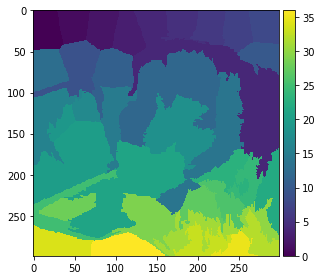

In [22]:
# Visualizamos primero los labels de la segmentación
imshow(imagen_segmentada)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


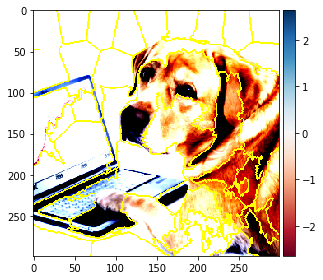

In [23]:
# Visualizamos la imagen de control con los bordes inducidos por los superpixeles. 
imshow(mark_boundaries(image=imagen_procesada,label_img=imagen_segmentada))

### 4

In [24]:
# Obtenemos los label únicos.
print(np.unique(imagen_segmentada))
print(len(np.unique(imagen_segmentada)))
# Notamos que van de 0 a 36. Luego son un total de 37 labels.
n_superpixeles = len(np.unique(imagen_segmentada))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36]
37


In [25]:
# Número de perturbaciones a realizar
n_perturbaciones = 1000 

# Se construye el arreglo de perturbaciones
#perturbaciones = bernoulli.rvs(0.5, loc=0, size=(n_perturbaciones,n_superpixeles))

# Se guardan en un .npy para luego solo importar.
#np.save("perturbaciones.npy",perturbaciones)

# Se cargan las perturbaciones previamente calculadas
perturbaciones = np.load("perturbaciones.npy")

# Notamos que son 1000 perturbaciones distintas para los 37 labels
print(perturbaciones.shape)

# Vemos una de las perturbaciones
print(perturbaciones[0])

(1000, 37)
[1 0 1 0 0 0 0 0 0 1 0 1 1 1 0 1 0 1 1 1 0 0 0 1 1 0 1 0 0 0 0 0 1 0 0 1 1]


### 5

In [26]:
def perturbar_imagen(imagen,perturbacion,segmentacion):
  '''Perturba una imagen ndarray.
  
  Genera un ndarray de dimensiones imagen.shape donde los canales de color
  de sus pixeles según el arreglo perturbacion.
  '''
  I,J,_ = imagen.shape
  imagen_perturbada=np.zeros_like(imagen)
  for i in range(I):
    for j in range(J):
      imagen_perturbada[i,j,:] = imagen_procesada[i,j,:]*perturbacion[segmentacion[i,j]]
  return imagen_perturbada

In [27]:
# Se genera un arreglo de imagenes perturbadas según el arreglo perturbaciones.
#imagenes_perturbadas = np.array([perturbar_imagen(
#    imagen_procesada,perturbacion,imagen_segmentada) for perturbacion in perturbaciones])
#np.save("imagenes_perturbadas.npy" ,arr=imagenes_perturbadas)

# Se carga el arreglo de imagenes perturbadas
imagenes_perturbadas = np.load("imagenes_perturbadas.npy")

In [28]:
# Se crean subarreglos de los primeros 10 y 100 imagenes por memoria.
#imagenes_perturbadas_10_2 = imagenes_perturbadas[:10,:,:,:]
#imagenes_perturbadas_100 = imagenes_perturbadas[:100,:,:,:]
#np.save("imagenes_perturbadas_10.npy",arr=imagenes_perturbadas_10)
#np.save("imagenes_perturbadas_100.npy",arr=imagenes_perturbadas_100)

# Se cargan los subarreglos
#imagenes_perturbadas_10 = np.load("imagenes_perturbadas_10.npy")
#imagenes_perturbadas_100 = np.load("imagenes_perturbadas_100.npy")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'perturbaciones[2]')

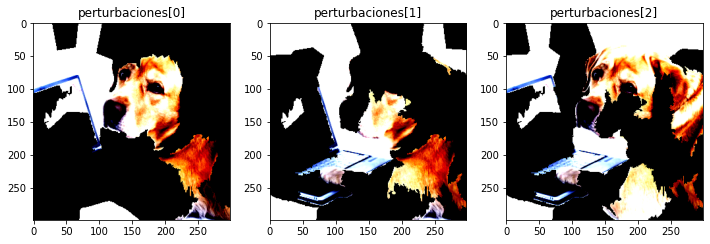

In [29]:
# Se muestran las 3 primeras perturbaciones de la imagen de control procesada
fig, ax = plt.subplots(nrows=1, ncols=3,figsize=[12,13])
#fig.suptitle('Perturbaciones de imagen de control')

ax[0].imshow(imagenes_perturbadas[0])
ax[0].set_title('perturbaciones[0]')

ax[1].imshow(imagenes_perturbadas[1])
ax[1].set_title('perturbaciones[1]')

ax[2].imshow(imagenes_perturbadas[2])
ax[2].set_title('perturbaciones[2]')

### 6

In [30]:
# Se crea el vector y
y = np.zeros(n_perturbaciones)

# Se procede a llenar y segun lo solicitado
for i in range(len(y)):
  imagen_i = imagenes_perturbadas[i]
  input_batch_i = torch.from_numpy(np.transpose(imagen_i,[2,0,1])).unsqueeze(0)
  input_batch_i = input_batch_i.to(dev)

  # Se calculan las probabilidades de cada clase
  output_i = modelo(input_batch_i)
  predicciones_i = torch.nn.functional.softmax(
    output_i[0], dim=0).cpu().detach().numpy().reshape([-1,1]).T
  
  # Se recupera la clase más probable
  prediccion_i = decode_predictions(predicciones_i)[0][0][1]
  
  # En caso de coincidir con la prediccion de la imagen de control
  if prediccion_i == prediccion_control:
    y[i] = 1

print('Cantidad de predicciones acertadas: {}'.format(sum(y)))

Cantidad de predicciones acertadas: 385.0


### 7

In [31]:
# Se crea un arreglo de 1's que corresponde a "no perturbar" la imagen original
imagen_original = np.ones(n_superpixeles).reshape(1,-1)
imagen_original

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1.]])

In [32]:
# Se calculan las distancias coseno
distancias = 1 - pairwise_distances(perturbaciones,imagen_original, metric='cosine').ravel()
#distancias = pairwise_distances(perturbaciones,imagen_original, metric='cosine').ravel()
print(distancias.shape)
#print(distancias)

(1000,)


In [33]:
# Se calcula pi_x
sigma = 0.25
pi_x = np.exp(-(distancias**2)/sigma**2)
print(pi_x.shape)

(1000,)


### 8

In [34]:
# Se genera el conjunto de entrenamiento D_p concatenando el vector y sobre
# el arreglo de perturbaciones
D_p = np.column_stack([perturbaciones,y])
D_p.shape

(1000, 38)

### 9

In [35]:
# Se crea el modelo de regresión logística y se ajusta a los datos de entrenamiento 
modelo_logistico = LogisticRegression()
modelo_logistico.fit(X=D_p[:,:-1], y=D_p[:,-1:].ravel(), sample_weight=pi_x)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

#### DISCUSION:

### 10

In [36]:
# Se guarda el vector con los coeficientes del ajuste anterior
coeficientes = modelo_logistico.coef_[0]

# Se consideran los super-pixeles más relevantes(con mayor peso) y los menos
# relevantes(menor peso), en la predicción.
n_sp = 4
mejores_superpixeles = np.argsort(coeficientes)[-n_sp:]
peores_superpixeles = np.argsort(coeficientes)[:n_sp]
print("Superpixeles de mayor peso: ", mejores_superpixeles)
print("Superpixeles de menor peso: ", peores_superpixeles)

Superpixeles de mayor peso:  [26  4 18 12]
Superpixeles de menor peso:  [21 15  0 34]


In [37]:
# Se crea una perturbacion mascara con los mejores_superpixeles
mascara_mejores, mascara_peores = np.zeros(n_superpixeles), np.zeros(n_superpixeles) 
mascara_mejores[mejores_superpixeles]= True #Activa los mejores superpixeles
mascara_peores[peores_superpixeles]= True #Activa los peores superpixeles

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Peores')

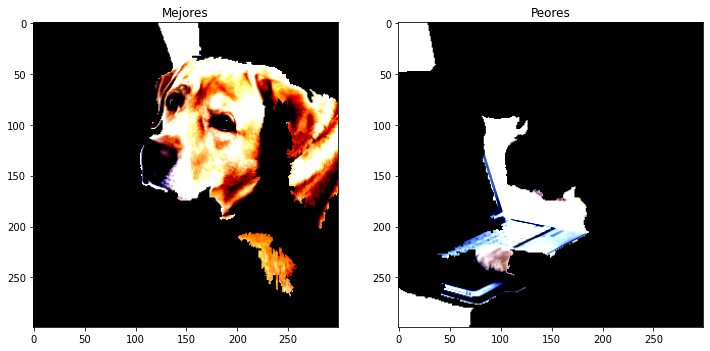

In [38]:
# Se perturba la imagen con la mascara
imagen_mascara_mejores = perturbar_imagen(imagen_procesada, mascara_mejores, imagen_segmentada)
imagen_mascara_peores = perturbar_imagen(imagen_procesada, mascara_peores, imagen_segmentada)

# Se muestra la imagen 
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=[12,13])
ax[0].imshow(imagen_mascara_mejores)
ax[0].set_title('Mejores')
ax[1].imshow(imagen_mascara_peores)
ax[1].set_title('Peores')

#### DISCUSION:

### 11

In [39]:
# Se crea un nuevo esquema de procesamiento para convertir la imagen de control
# a grayscale.
procesamiento_gs = transforms.Compose([transforms.Resize(size=299, interpolation=2),
                                     transforms.CenterCrop(299),
                                     ])

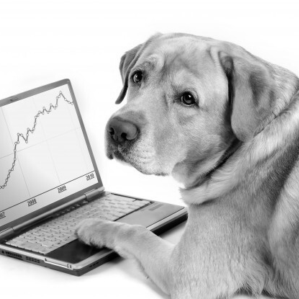

In [40]:
# Procedemos a hacer la transformacion
imagen_procesada_gs = procesamiento_gs(imagen_control)
#imagen_procesada_gs = transforms.ToPILImage(mode="RGB")(imagen_procesada_gs)
imagen_procesada_gs = imagen_procesada_gs.convert("L")
imagen_procesada_gs

In [41]:
# La convertimos en arreglo de numpy para trabajar en la clusterizacion
imagen_procesada_gs = np.asarray(imagen_procesada_gs)
print(imagen_procesada_gs.shape)
imagen_procesada_gs

(299, 299)


array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [254, 254, 254, ..., 254, 254, 254],
       ...,
       [255, 255, 255, ..., 121, 126, 129],
       [255, 255, 255, ..., 119, 126, 127],
       [255, 255, 255, ..., 117, 123, 125]], dtype=uint8)

In [42]:
# Creamos el conjunto de entrenamiento X
X = np.array( [ [i,j,imagen_procesada_gs[i,j]]
               for i in range(299) for j in range(299)])

# Notamos que tiene largo 299*299 y cada fila corresponde a una observación
# donde las primeras 2 componentes son espaciales y la tercera es el color
print(X.shape)
X

(89401, 3)


array([[  0,   0, 255],
       [  0,   1, 255],
       [  0,   2, 255],
       ...,
       [298, 296, 117],
       [298, 297, 123],
       [298, 298, 125]])

In [84]:
# Fijamos el numero de clusters como la cantidad de superpixeles obtenidos antes
# para reutilizar el arreglo de perturbaciones creado previamente
n_clusters = n_superpixeles
n_clusters

37

In [85]:
# KMeans
# Creamos el cluster KMeans con n_cluster clusters y ajustamos al conjunto de entrenamiento 
km_cluster = KMeans(n_clusters=n_clusters)
km_cluster.fit_predict(X)

# Obtenemos los labels(superpixeles) y los centros de cada cluster
km_labels, km_centers = km_cluster.labels_, km_cluster.cluster_centers_.squeeze()
print(km_labels.shape)
print(km_labels)
print(np.unique(km_labels))

(89401,)
[ 6  6  6 ... 33 33 33]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36]


In [86]:
# Recuperamos la estructura original de la imagen descrita por superpixeles
km_labels = km_labels.reshape(299,299)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


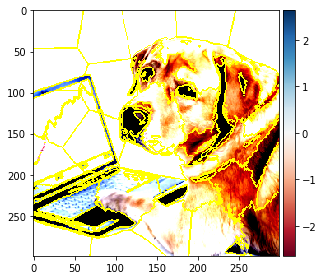

In [87]:
# Obtenemos una visualización de los bordes que inducen los superpixeles 
# obtenidos por KMeans sobre la imagen de control
imshow(mark_boundaries(image=imagen_procesada,label_img=km_labels))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'superpixel 5')

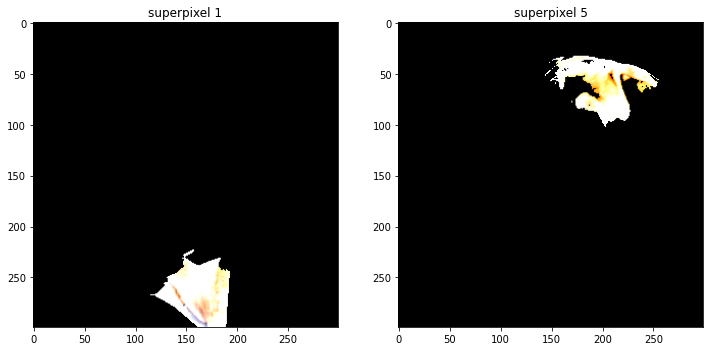

In [89]:
# Visualizamos algunos clusters obtenidos de éste metodo
i,j = 1,5
mascara_i, mascara_j = np.zeros(n_clusters),np.zeros(n_clusters)
mascara_i[i], mascara_j[j]= True, True
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=[12,13])
ax[0].imshow(perturbar_imagen(imagen_procesada,mascara_i,km_labels))
ax[0].set_title('superpixel {}'.format(i))
ax[1].imshow(perturbar_imagen(imagen_procesada,mascara_j,km_labels))
ax[1].set_title('superpixel {}'.format(j))

In [90]:
# MiniBatchKMeans
# Creamos el cluster MeanShift y ajustamos al conjunto de entrenamiento 
mbkm_cluster = MiniBatchKMeans(n_clusters=n_clusters, batch_size=16, random_state=0)
mbkm_cluster.fit_predict(X)

# Obtenemos los labels(superpixeles) y los centros de cada cluster
mbkm_labels, mbkm_centers = mbkm_cluster.labels_, mbkm_cluster.cluster_centers_.squeeze()
print(mbkm_labels.shape)
print(mbkm_labels)
print(np.unique(mbkm_labels))

(89401,)
[22 22 22 ... 35 35 35]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36]


In [91]:
# Recuperamos la estructura original de la imagen descrita por superpixeles
mbkm_labels = mbkm_labels.reshape(299,299)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


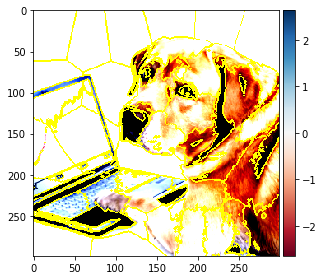

In [92]:
# Obtenemos una visualización de los bordes que inducen los superpixeles 
# obtenidos por KMeans sobre la imagen de control
imshow(mark_boundaries(image=imagen_procesada,label_img=mbkm_labels))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Cluster 2')

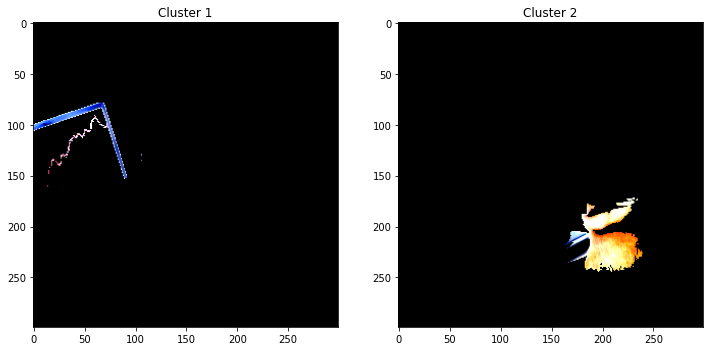

In [93]:
# Visualizamos algunos clusters obtenidos de éste metodo
i,j = 1,2
mascara_i, mascara_j = np.zeros(n_clusters),np.zeros(n_clusters)
mascara_i[i], mascara_j[j]= True, True
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=[12,13])
ax[0].imshow(perturbar_imagen(imagen_procesada, mascara_i, mbkm_labels))
ax[0].set_title('Cluster {}'.format(i))
ax[1].imshow(perturbar_imagen(imagen_procesada, mascara_j, mbkm_labels))
ax[1].set_title('Cluster {}'.format(j))

### 12

#### KMeans

In [94]:
# Se genera un arreglo de imagenes perturbadas según el arreglo perturbaciones.
#imagenes_perturbadas_km = np.array([perturbar_imagen(
#    imagen_procesada,perturbacion,km_labels) for perturbacion in perturbaciones])

# Se guarda el arreglo de imagenes perturbadas para replicabilidad. 
#np.save("imagenes_perturbadas_km.npy" , arr=imagenes_perturbadas_km)

# Se carga el arreglo de imagenes perturbadas
imagenes_perturbadas_km = np.load("imagenes_perturbadas_km.npy")
imagenes_perturbadas_km.shape

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


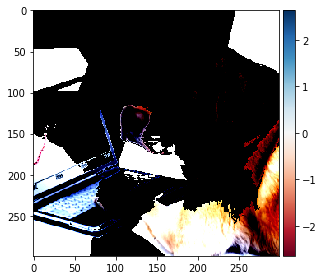

In [105]:
imshow(imagenes_perturbadas_km[8])

In [106]:
# Se crea el vector y_km
y_km = np.zeros(n_perturbaciones)

# Se procede a llenar y segun lo solicitado
for i in range(len(y_km)):
  imagen_i = imagenes_perturbadas_km[i]
  input_batch_i = torch.from_numpy(np.transpose(imagen_i,[2,0,1])).unsqueeze(0)
  input_batch_i = input_batch_i.to(dev)

  # Se calculan las probabilidades de cada clase
  output_i = modelo(input_batch_i)
  predicciones_i = torch.nn.functional.softmax(
    output_i[0], dim=0).cpu().detach().numpy().reshape([-1,1]).T
  
  # Se recupera la clase más probable
  prediccion_i = decode_predictions(predicciones_i)[0][0][1]
  
  # En caso de coincidir con la prediccion de la imagen de control
  if prediccion_i == prediccion_control:
    y_km[i] = 1

print('Cantidad de predicciones acertadas: {}'.format(sum(y_km)))

Cantidad de predicciones acertadas: 417.0


In [109]:
# Se genera el conjunto de entrenamiento D_p_km concatenando el vector y sobre
# el arreglo de perturbaciones
D_p_km = np.column_stack([perturbaciones,y_km])
D_p_km.shape

(1000, 38)

In [110]:
# Se crea el modelo de regresión logística y se ajusta a los datos de entrenamiento 
modelo_logistico_km = LogisticRegression()
modelo_logistico_km.fit(X=D_p_km[:,:-1], y=D_p_km[:,-1:].ravel(), sample_weight=pi_x)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Superpixeles de mayor peso:  [19 34 17 20]
Superpixeles de menor peso:  [18  0 11 27]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Peores')

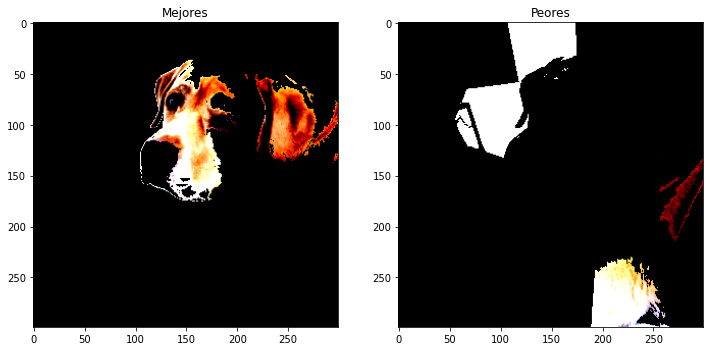

In [111]:
# Se guarda el vector con los coeficientes del ajuste anterior
coeficientes_km = modelo_logistico_km.coef_[0]

# Se consideran los superpixeles más relevantes(con mayor peso) y los menos
# relevantes(menor peso), en la predicción.
n_sp = 4
mejores_superpixeles_km = np.argsort(coeficientes_km)[-n_sp:]
peores_superpixeles_km = np.argsort(coeficientes_km)[:n_sp]
print("Superpixeles de mayor peso: ", mejores_superpixeles_km)
print("Superpixeles de menor peso: ", peores_superpixeles_km)

# Se crea una perturbacion mascara con los mejores_superpixeles
mascara_mejores_km, mascara_peores_km = np.zeros(n_superpixeles), np.zeros(n_superpixeles) 
mascara_mejores_km[mejores_superpixeles_km]= True #Activa los mejores superpixeles
mascara_peores_km[peores_superpixeles_km]= True #Activa los peores superpixeles

# Se perturba la imagen con la mascara
imagen_mascara_mejores_km = perturbar_imagen(imagen_procesada, mascara_mejores_km, km_labels)
imagen_mascara_peores_km = perturbar_imagen(imagen_procesada, mascara_peores_km, km_labels)

# Se muestra la imagen 
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=[12,13])
ax[0].imshow(imagen_mascara_mejores_km)
ax[0].set_title('Mejores')
ax[1].imshow(imagen_mascara_peores_km)
ax[1].set_title('Peores')

DISCUSION:

#### MiniBatchKMeans

In [112]:
# Se genera un arreglo de imagenes perturbadas según el arreglo perturbaciones.
#imagenes_perturbadas_mbkm = np.array([perturbar_imagen(
#    imagen_procesada,perturbacion,mbkm_labels) for perturbacion in perturbaciones])

# Se guarda el arreglo de imagenes perturbadas para replicabilidad. 
#np.save("imagenes_perturbadas_mbkm.npy" , arr=imagenes_perturbadas_mbkm)

# Se carga el arreglo de imagenes perturbadas
imagenes_perturbadas_mbkm = np.load("imagenes_perturbadas_mbkm.npy")
imagenes_perturbadas_mbkm.shape

In [113]:
# Se crea el vector y_mbkm
y_mbkm = np.zeros(n_perturbaciones)

# Se procede a llenar y segun lo solicitado
for i in range(len(y_mbkm)):
  imagen_i = imagenes_perturbadas_mbkm[i]
  input_batch_i = torch.from_numpy(np.transpose(imagen_i,[2,0,1])).unsqueeze(0)
  input_batch_i = input_batch_i.to(dev)

  # Se calculan las probabilidades de cada clase
  output_i = modelo(input_batch_i)
  predicciones_i = torch.nn.functional.softmax(
    output_i[0], dim=0).cpu().detach().numpy().reshape([-1,1]).T
  
  # Se recupera la clase más probable
  prediccion_i = decode_predictions(predicciones_i)[0][0][1]
  
  # En caso de coincidir con la prediccion de la imagen de control
  if prediccion_i == prediccion_control:
    y_mbkm[i] = 1

print('Cantidad de predicciones acertadas: {}'.format(sum(y_mbkm)))

Cantidad de predicciones acertadas: 465.0


In [114]:
# Se genera el conjunto de entrenamiento D_p_mbkm concatenando el vector y sobre
# el arreglo de perturbaciones
D_p_mbkm = np.column_stack([perturbaciones,y_mbkm])
D_p_mbkm.shape

(1000, 38)

In [115]:
# Se crea el modelo de regresión logística y se ajusta a los datos de entrenamiento 
modelo_logistico_mbkm = LogisticRegression()
modelo_logistico_mbkm.fit(X=D_p_mbkm[:,:-1], y=D_p_mbkm[:,-1:].ravel(), sample_weight=pi_x)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Superpixeles de mayor peso:  [20  7 32  3]
Superpixeles de menor peso:  [13 22 27 15]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Peores')

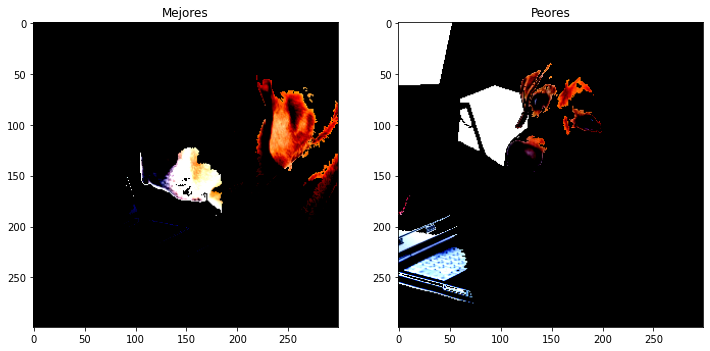

In [116]:
# Se guarda el vector con los coeficientes del ajuste anterior
coeficientes_mbkm = modelo_logistico_mbkm.coef_[0]

# Se consideran los superpixeles más relevantes(con mayor peso) y los menos
# relevantes(menor peso), en la predicción.
n_sp = 4
mejores_superpixeles_mbkm = np.argsort(coeficientes_mbkm)[-n_sp:]
peores_superpixeles_mbkm = np.argsort(coeficientes_mbkm)[:n_sp]
print("Superpixeles de mayor peso: ", mejores_superpixeles_mbkm)
print("Superpixeles de menor peso: ", peores_superpixeles_mbkm)

# Se crea una perturbacion mascara con los mejores_superpixeles
mascara_mejores_mbkm, mascara_peores_mbkm = np.zeros(n_superpixeles), np.zeros(n_superpixeles) 
mascara_mejores_mbkm[mejores_superpixeles_mbkm]= True #Activa los mejores superpixeles
mascara_peores_mbkm[peores_superpixeles_mbkm]= True #Activa los peores superpixeles

# Se perturba la imagen con la mascara
imagen_mascara_mejores_mbkm = perturbar_imagen(imagen_procesada, mascara_mejores_mbkm, mbkm_labels)
imagen_mascara_peores_mbkm = perturbar_imagen(imagen_procesada, mascara_peores_mbkm, mbkm_labels)

# Se muestra la imagen 
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=[12,13])
ax[0].imshow(imagen_mascara_mejores_mbkm)
ax[0].set_title('Mejores')
ax[1].imshow(imagen_mascara_peores_mbkm)
ax[1].set_title('Peores')

DISCUSION:

### 13